# Regularization: A Complete Guide to Preventing Overfitting

## Table of Contents
1. [Introduction to Regularization](#intro)
2. [The Bias-Variance Trade-off](#bias-variance)
3. [Overfitting and Underfitting](#overfitting)
4. [L2 Regularization (Ridge Regression)](#ridge)
5. [L1 Regularization (Lasso Regression)](#lasso)
6. [Elastic Net Regularization](#elastic-net)
7. [Regularization Parameter Selection](#parameter-selection)
8. [Regularization Paths](#regularization-paths)
9. [Feature Selection with Regularization](#feature-selection)
10. [Practical Applications](#applications)

---

## 1. Introduction to Regularization <a id='intro'></a>

**Regularization** is a fundamental technique in machine learning to prevent overfitting by adding a penalty term to the loss function. It constrains or shrinks the coefficient estimates towards zero.

### The Problem: Overfitting

When we train a model, we want it to:
- Perform well on training data (low training error)
- Generalize well to new, unseen data (low test error)

**Overfitting** occurs when a model learns the training data too well, including its noise and outliers, leading to poor generalization.

### The Solution: Regularization

Regularization adds a penalty term to the loss function:

$$\text{Total Loss} = \text{Data Loss} + \lambda \times \text{Regularization Term}$$

Where:
- **Data Loss**: Measures how well the model fits the training data (e.g., MSE, cross-entropy)
- **Regularization Term**: Penalizes model complexity
- **Lambda (λ)**: Controls the strength of regularization (hyperparameter)

### Types of Regularization

1. **L2 Regularization (Ridge)**: Penalizes sum of squared coefficients
2. **L1 Regularization (Lasso)**: Penalizes sum of absolute coefficients
3. **Elastic Net**: Combination of L1 and L2
4. **Dropout**: Randomly dropping neurons during training (for neural networks)
5. **Early Stopping**: Stop training before overfitting occurs
6. **Data Augmentation**: Increase training data diversity

### Mathematical Foundation

For linear regression, the ordinary least squares (OLS) objective is:

$$\min_{\mathbf{w}} \|\mathbf{y} - \mathbf{Xw}\|_2^2$$

With regularization, we modify this to:

$$\min_{\mathbf{w}} \|\mathbf{y} - \mathbf{Xw}\|_2^2 + \lambda R(\mathbf{w})$$

Where $R(\mathbf{w})$ is the regularization term.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.datasets import make_regression, load_diabetes
import pandas as pd
import warnings

# Set styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully
NumPy version: 2.0.2
Pandas version: 2.2.2


## 2. The Bias-Variance Trade-off <a id='bias-variance'></a>

Understanding the bias-variance trade-off is crucial to understanding regularization.

### Decomposition of Expected Test Error

The expected test error can be decomposed into three components:

$$\mathbb{E}[(y - \hat{f}(x))^2] = \text{Bias}^2[\hat{f}(x)] + \text{Var}[\hat{f}(x)] + \sigma^2$$

Where:
- **Bias**: Error from erroneous assumptions in the learning algorithm
  $$\text{Bias}[\hat{f}(x)] = \mathbb{E}[\hat{f}(x)] - f(x)$$
  
- **Variance**: Error from sensitivity to small fluctuations in the training set
  $$\text{Var}[\hat{f}(x)] = \mathbb{E}[(\hat{f}(x) - \mathbb{E}[\hat{f}(x)])^2]$$
  
- **Irreducible Error**: Noise in the true relationship ($\sigma^2$)

### Characteristics

**High Bias (Underfitting)**:
- Model is too simple
- Poor performance on both training and test data
- Fails to capture underlying patterns
- Example: Linear model for non-linear data

**High Variance (Overfitting)**:
- Model is too complex
- Excellent performance on training data
- Poor performance on test data
- Captures noise as if it were signal
- Example: High-degree polynomial for simple data

**The Trade-off**:
- Increasing model complexity: Decreases bias, increases variance
- Decreasing model complexity: Increases bias, decreases variance
- Goal: Find the sweet spot that minimizes total error

### How Regularization Helps

Regularization increases bias slightly while significantly reducing variance, often leading to better overall performance on test data.

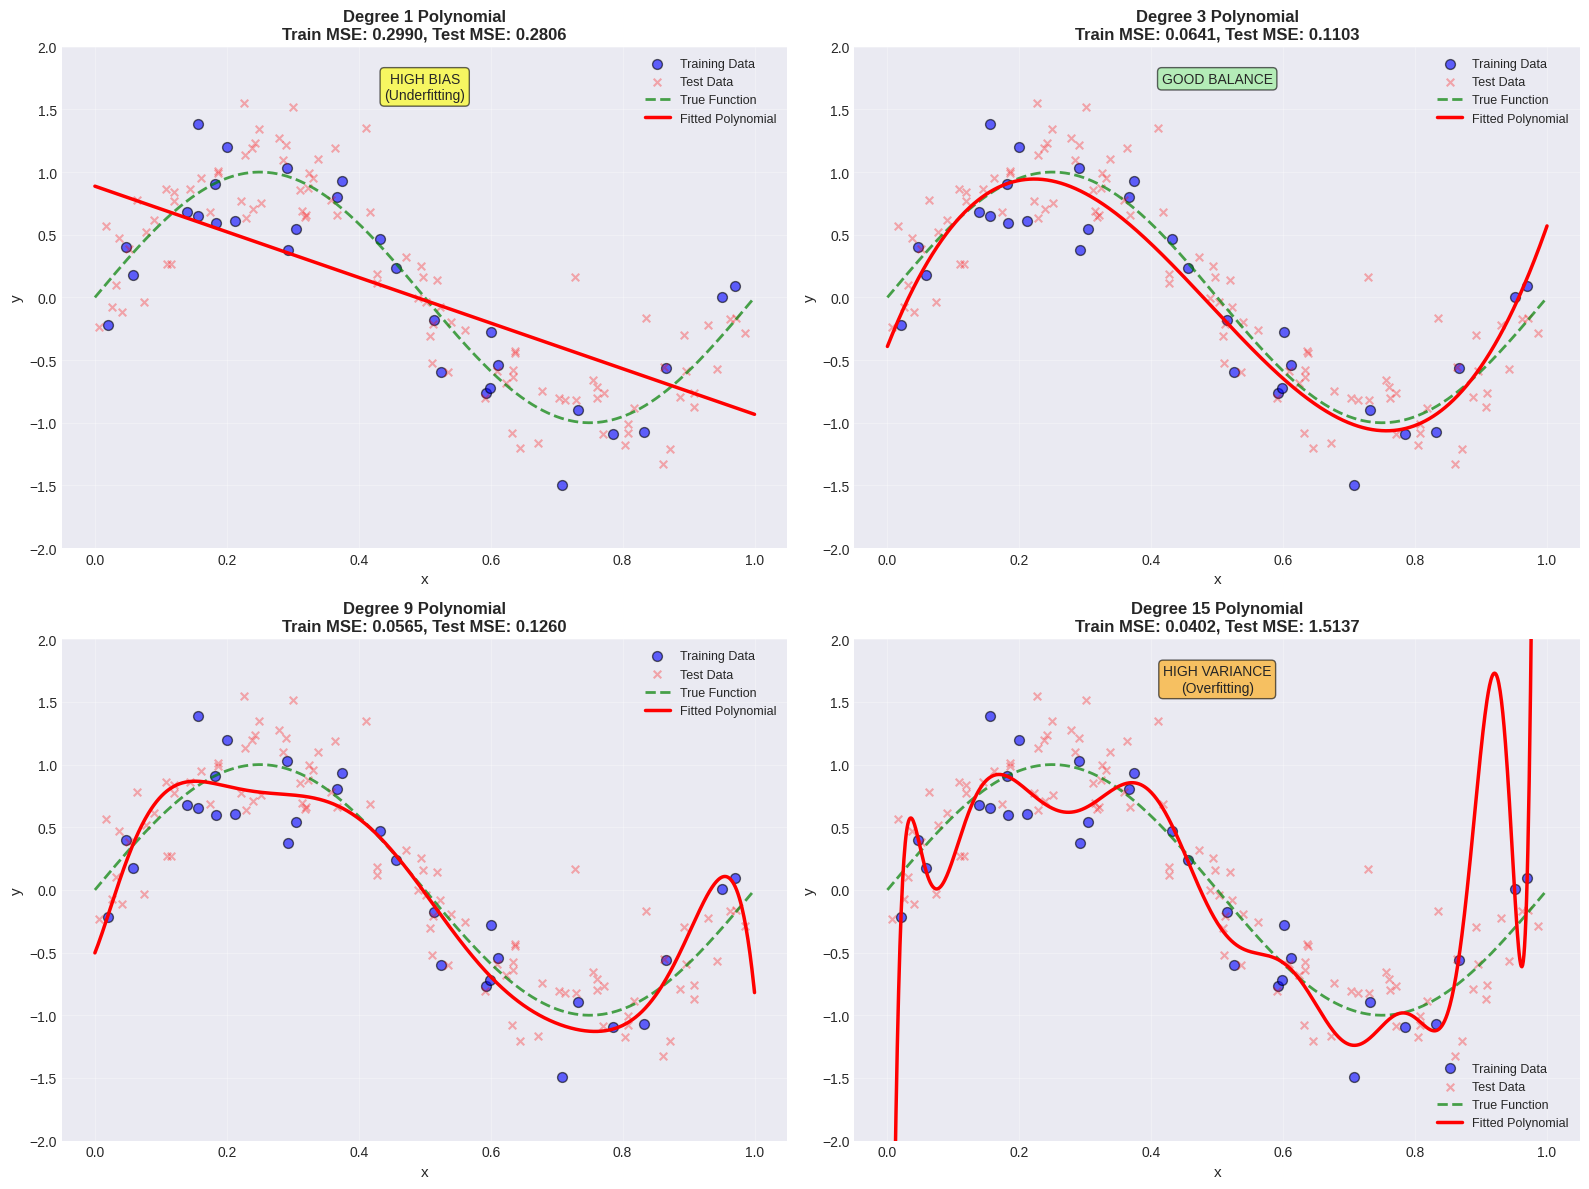

Bias-Variance Trade-off Demonstration:
Degree 1: Underfitting - too simple, high bias
Degree 3: Good fit - balanced bias and variance
Degree 9: Starting to overfit - increasing variance
Degree 15: Severe overfitting - very high variance


In [2]:
# Demonstrate bias-variance trade-off with polynomial regression

def generate_data(n_samples=100, noise=0.3):
    """
    Generate synthetic data for demonstration
    True function: y = sin(2*pi*x) + noise
    """
    X = np.sort(np.random.rand(n_samples))
    y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * noise
    return X.reshape(-1, 1), y

# Generate training and test data
X_train, y_train = generate_data(n_samples=30, noise=0.3)
X_test, y_test = generate_data(n_samples=100, noise=0.3)

# True function for comparison
X_true = np.linspace(0, 1, 1000).reshape(-1, 1)
y_true = np.sin(2 * np.pi * X_true.ravel())

# Test different polynomial degrees
degrees = [1, 3, 9, 15]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, degree in enumerate(degrees):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    X_true_poly = poly.transform(X_true)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    y_true_pred = model.predict(X_true_poly)
    
    # Calculate errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Plot
    axes[idx].scatter(X_train, y_train, color='blue', s=50, alpha=0.6, 
                     label='Training Data', edgecolors='black', linewidths=1)
    axes[idx].scatter(X_test, y_test, color='red', s=30, alpha=0.3,
                     label='Test Data', marker='x')
    axes[idx].plot(X_true, y_true, 'g--', linewidth=2, alpha=0.7,
                  label='True Function')
    axes[idx].plot(X_true, y_true_pred, 'r-', linewidth=2.5,
                  label='Fitted Polynomial')
    
    axes[idx].set_xlabel('x', fontsize=11)
    axes[idx].set_ylabel('y', fontsize=11)
    axes[idx].set_title(f'Degree {degree} Polynomial\nTrain MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}',
                       fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim([-2, 2])
    
    # Add annotation
    if degree == 1:
        axes[idx].text(0.5, 0.95, 'HIGH BIAS\n(Underfitting)',
                      transform=axes[idx].transAxes, fontsize=10,
                      verticalalignment='top', ha='center',
                      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))
    elif degree == 15:
        axes[idx].text(0.5, 0.95, 'HIGH VARIANCE\n(Overfitting)',
                      transform=axes[idx].transAxes, fontsize=10,
                      verticalalignment='top', ha='center',
                      bbox=dict(boxstyle='round', facecolor='orange', alpha=0.6))
    elif degree == 3:
        axes[idx].text(0.5, 0.95, 'GOOD BALANCE',
                      transform=axes[idx].transAxes, fontsize=10,
                      verticalalignment='top', ha='center',
                      bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.6))

plt.tight_layout()
plt.show()

print("Bias-Variance Trade-off Demonstration:")
print("="*70)
print("Degree 1: Underfitting - too simple, high bias")
print("Degree 3: Good fit - balanced bias and variance")
print("Degree 9: Starting to overfit - increasing variance")
print("Degree 15: Severe overfitting - very high variance")

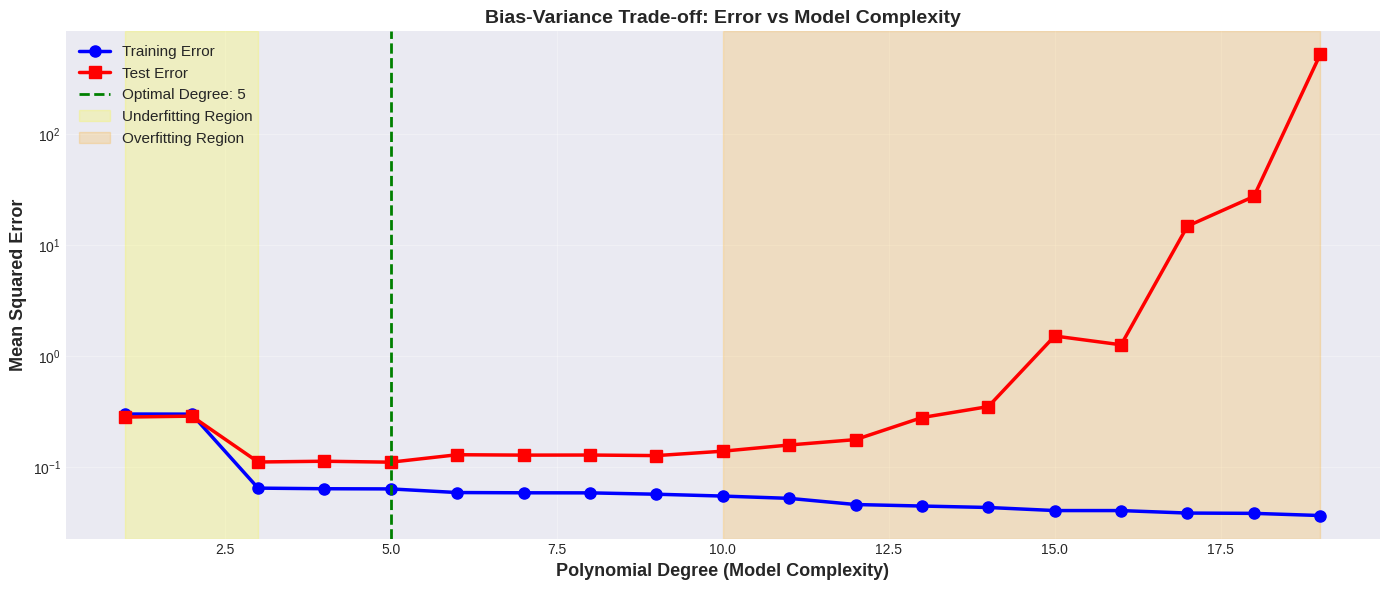


Optimal polynomial degree: 5
Minimum test error: 0.109906

Key Observations:
  - Training error consistently decreases with complexity
  - Test error initially decreases then increases
  - Gap between training and test error indicates overfitting


In [3]:
# Visualize bias-variance trade-off curve

degrees_range = range(1, 20)
train_errors = []
test_errors = []

for degree in degrees_range:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    train_errors.append(mean_squared_error(y_train, model.predict(X_train_poly)))
    test_errors.append(mean_squared_error(y_test, model.predict(X_test_poly)))

# Plot
plt.figure(figsize=(14, 6))

plt.plot(degrees_range, train_errors, 'o-', linewidth=2.5, markersize=8,
         label='Training Error', color='blue')
plt.plot(degrees_range, test_errors, 's-', linewidth=2.5, markersize=8,
         label='Test Error', color='red')

# Mark optimal point
optimal_degree = degrees_range[np.argmin(test_errors)]
plt.axvline(x=optimal_degree, color='green', linestyle='--', linewidth=2,
           label=f'Optimal Degree: {optimal_degree}')

# Add regions
plt.axvspan(1, 3, alpha=0.2, color='yellow', label='Underfitting Region')
plt.axvspan(10, 19, alpha=0.2, color='orange', label='Overfitting Region')

plt.xlabel('Polynomial Degree (Model Complexity)', fontsize=13, fontweight='bold')
plt.ylabel('Mean Squared Error', fontsize=13, fontweight='bold')
plt.title('Bias-Variance Trade-off: Error vs Model Complexity', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

print(f"\nOptimal polynomial degree: {optimal_degree}")
print(f"Minimum test error: {min(test_errors):.6f}")
print("\nKey Observations:")
print("  - Training error consistently decreases with complexity")
print("  - Test error initially decreases then increases")
print("  - Gap between training and test error indicates overfitting")

## 3. Overfitting and Underfitting <a id='overfitting'></a>

### Underfitting (High Bias)

**Definition**: Model is too simple to capture the underlying structure of the data.

**Symptoms**:
- High training error
- High test error
- Training and test errors are similar
- Model assumptions don't match the data

**Solutions**:
- Increase model complexity
- Add more features
- Reduce regularization strength
- Train longer (for iterative methods)

### Overfitting (High Variance)

**Definition**: Model is too complex and learns noise in the training data.

**Symptoms**:
- Very low training error
- High test error
- Large gap between training and test errors
- Model performs poorly on new data

**Solutions**:
- Decrease model complexity
- Add regularization (L1, L2, or both)
- Get more training data
- Feature selection
- Cross-validation
- Early stopping
- Ensemble methods

### Detecting Overfitting

**Learning Curves**: Plot training and validation error vs training set size
- Overfitting: Large gap between curves
- Underfitting: Both errors remain high

**Validation Curves**: Plot error vs model complexity
- Sweet spot: Where validation error is minimized

**Cross-Validation**: Use k-fold CV to estimate generalization error
- Large variance in CV scores indicates overfitting

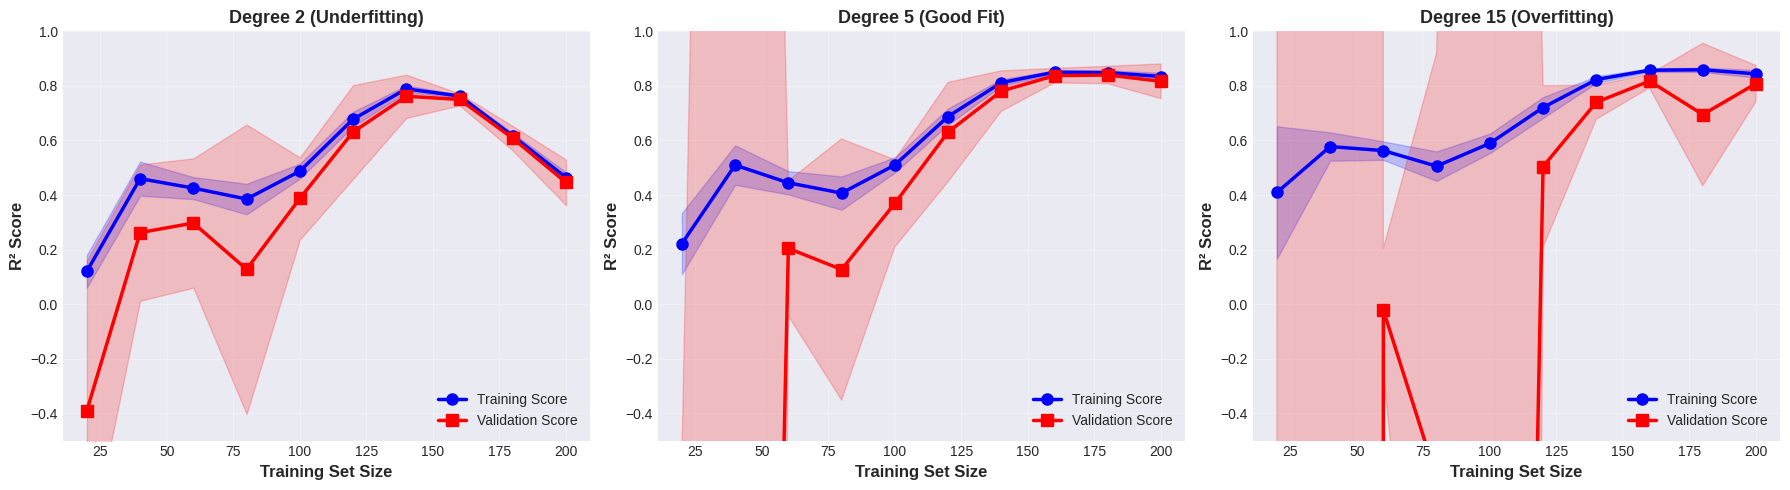

Learning Curve Interpretation:
Underfitting (Degree 2):
  - Both curves plateau at low scores
  - Small gap between training and validation
  - More data will not help much

Good Fit (Degree 5):
  - Both curves converge to high scores
  - Moderate gap between curves
  - Model generalizes well

Overfitting (Degree 15):
  - Large gap between training and validation
  - Training score very high, validation lower
  - More data might help reduce the gap


In [4]:
# Generate learning curves to diagnose overfitting/underfitting

def plot_learning_curves(model, X, y, title="Learning Curves"):
    """
    Plot learning curves for a given model
    """
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_scores_mean = []
    train_scores_std = []
    val_scores_mean = []
    val_scores_std = []
    
    for train_size in train_sizes:
        n_samples = int(train_size * len(X))
        
        # Use cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        train_scores = []
        val_scores = []
        
        for train_idx, val_idx in kf.split(X[:n_samples]):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            
            train_scores.append(model.score(X_train_fold, y_train_fold))
            val_scores.append(model.score(X_val_fold, y_val_fold))
        
        train_scores_mean.append(np.mean(train_scores))
        train_scores_std.append(np.std(train_scores))
        val_scores_mean.append(np.mean(val_scores))
        val_scores_std.append(np.std(val_scores))
    
    train_scores_mean = np.array(train_scores_mean)
    train_scores_std = np.array(train_scores_std)
    val_scores_mean = np.array(val_scores_mean)
    val_scores_std = np.array(val_scores_std)
    train_sizes_abs = (train_sizes * len(X)).astype(int)
    
    return train_sizes_abs, train_scores_mean, train_scores_std, val_scores_mean, val_scores_std

# Generate data with more samples
X_full, y_full = generate_data(n_samples=200, noise=0.3)

# Create polynomial features
poly_low = PolynomialFeatures(degree=2)  # Underfit
poly_good = PolynomialFeatures(degree=5)  # Good fit
poly_high = PolynomialFeatures(degree=15)  # Overfit

X_poly_low = poly_low.fit_transform(X_full)
X_poly_good = poly_good.fit_transform(X_full)
X_poly_high = poly_high.fit_transform(X_full)

# Create models
models = [
    (LinearRegression(), X_poly_low, "Degree 2 (Underfitting)"),
    (LinearRegression(), X_poly_good, "Degree 5 (Good Fit)"),
    (LinearRegression(), X_poly_high, "Degree 15 (Overfitting)")
]

# Plot learning curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model, X_data, title) in enumerate(models):
    sizes, train_mean, train_std, val_mean, val_std = plot_learning_curves(
        model, X_data, y_full, title
    )
    
    # Plot training score
    axes[idx].plot(sizes, train_mean, 'o-', color='blue', linewidth=2.5,
                  markersize=8, label='Training Score')
    axes[idx].fill_between(sizes, train_mean - train_std, train_mean + train_std,
                           alpha=0.2, color='blue')
    
    # Plot validation score
    axes[idx].plot(sizes, val_mean, 's-', color='red', linewidth=2.5,
                  markersize=8, label='Validation Score')
    axes[idx].fill_between(sizes, val_mean - val_std, val_mean + val_std,
                           alpha=0.2, color='red')
    
    axes[idx].set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('R² Score', fontsize=12, fontweight='bold')
    axes[idx].set_title(title, fontsize=13, fontweight='bold')
    axes[idx].legend(fontsize=10, loc='lower right')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim([-0.5, 1.0])

plt.tight_layout()
plt.show()

print("Learning Curve Interpretation:")
print("="*70)
print("Underfitting (Degree 2):")
print("  - Both curves plateau at low scores")
print("  - Small gap between training and validation")
print("  - More data will not help much")
print("\nGood Fit (Degree 5):")
print("  - Both curves converge to high scores")
print("  - Moderate gap between curves")
print("  - Model generalizes well")
print("\nOverfitting (Degree 15):")
print("  - Large gap between training and validation")
print("  - Training score very high, validation lower")
print("  - More data might help reduce the gap")

## 4. L2 Regularization (Ridge Regression) <a id='ridge'></a>

### Mathematical Formulation

Ridge regression adds an L2 penalty term to the ordinary least squares objective:

$$\min_{\mathbf{w}} \|\mathbf{y} - \mathbf{Xw}\|_2^2 + \lambda \|\mathbf{w}\|_2^2$$

Where:
- $\|\mathbf{y} - \mathbf{Xw}\|_2^2 = \sum_{i=1}^{n} (y_i - \mathbf{w}^T\mathbf{x}_i)^2$ is the sum of squared residuals
- $\|\mathbf{w}\|_2^2 = \sum_{j=1}^{p} w_j^2$ is the L2 norm (Euclidean norm) of weights
- $\lambda \geq 0$ is the regularization parameter

### Closed-Form Solution

Ridge regression has a closed-form solution:

$$\mathbf{w}_{\text{ridge}} = (\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$

Where $\mathbf{I}$ is the identity matrix.

### Properties

**Shrinkage**: Ridge regression shrinks coefficients towards zero, but never exactly to zero

**Stability**: Adding $\lambda \mathbf{I}$ to $\mathbf{X}^T\mathbf{X}$ improves numerical stability and handles multicollinearity

**All Features Retained**: Does not perform feature selection

**Scale Dependence**: Penalty depends on scale of features - standardization is crucial

### When to Use Ridge

- When you have many correlated features
- When you want to keep all features in the model
- When dealing with multicollinearity
- When $n < p$ (more features than samples)

### Geometric Interpretation

Ridge regression constrains the solution to lie within a sphere (L2 ball) of radius $t$:

$$\|\mathbf{w}\|_2^2 \leq t$$

The solution is found at the point where the constraint region touches the smallest level set of the loss function.

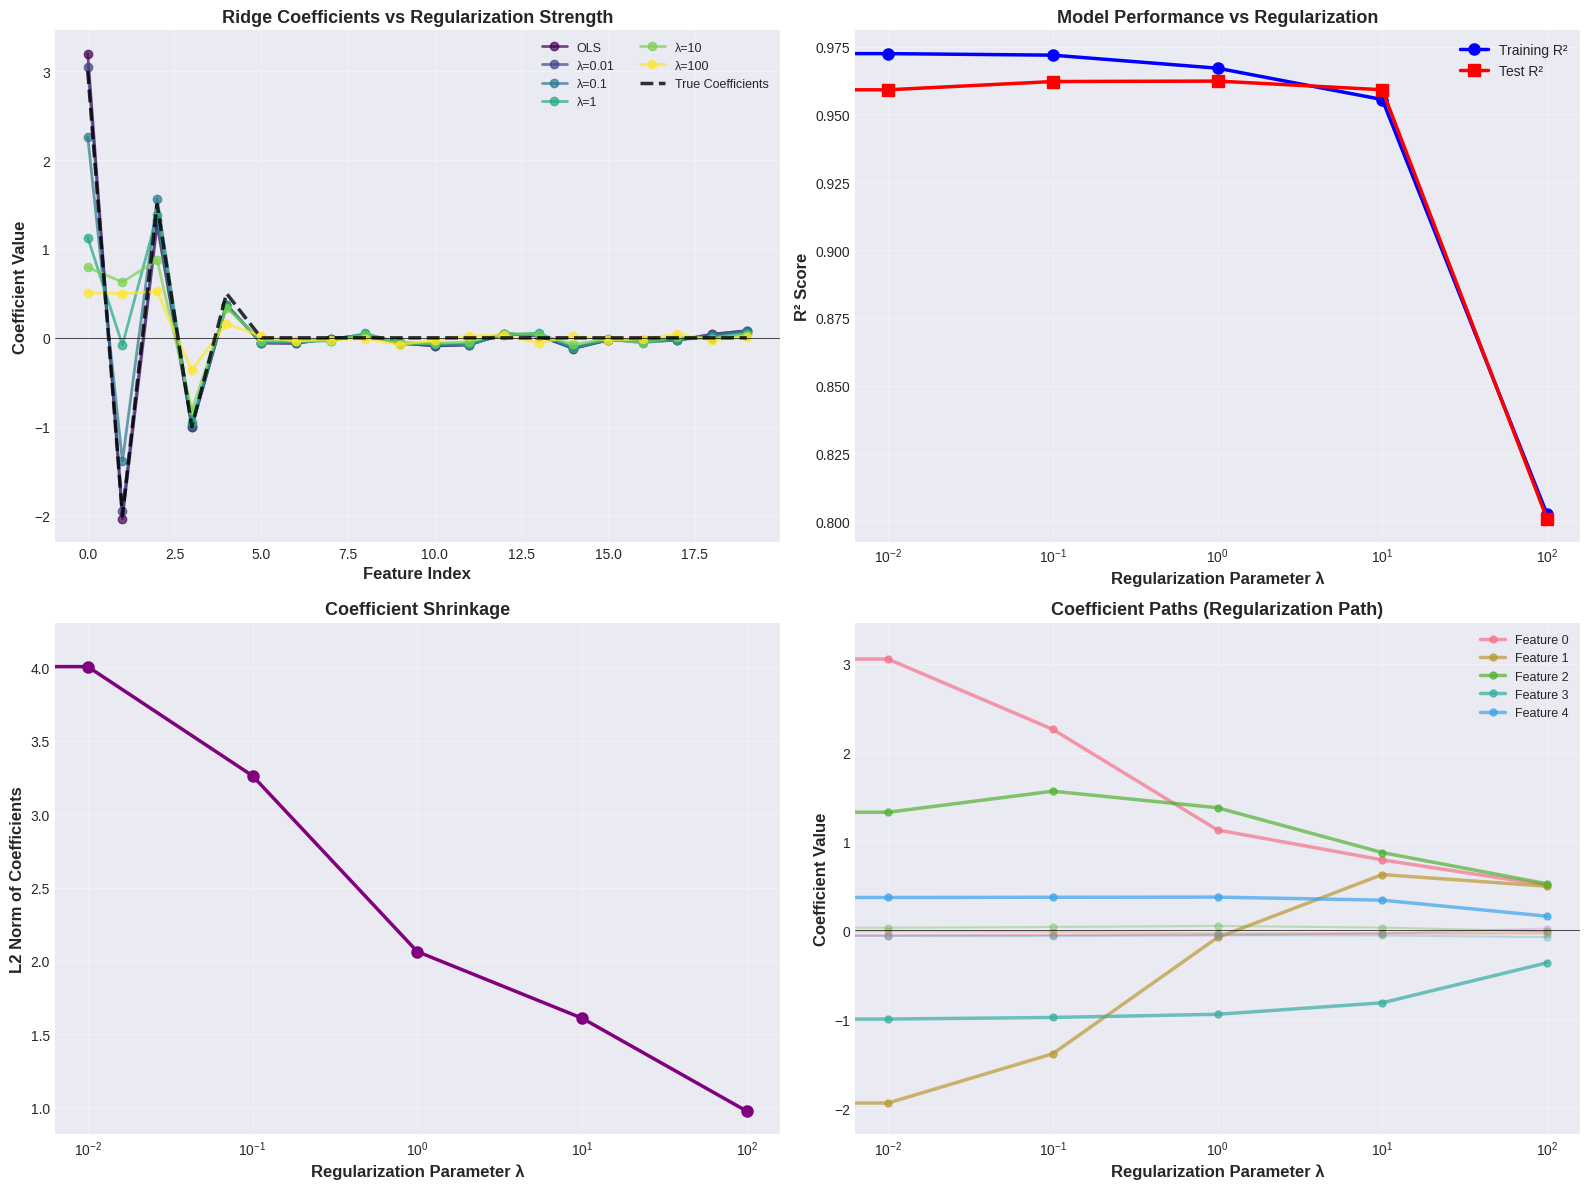

Ridge Regression Results:

λ =   0.00: Train R² = 0.9724, Test R² = 0.9584, ||w||₂ = 4.1455

λ =   0.01: Train R² = 0.9724, Test R² = 0.9591, ||w||₂ = 4.0055

λ =   0.10: Train R² = 0.9718, Test R² = 0.9621, ||w||₂ = 3.2619

λ =   1.00: Train R² = 0.9670, Test R² = 0.9623, ||w||₂ = 2.0640

λ =  10.00: Train R² = 0.9555, Test R² = 0.9591, ||w||₂ = 1.6104

λ = 100.00: Train R² = 0.8026, Test R² = 0.8010, ||w||₂ = 0.9768

Key Observations:
  - As λ increases, coefficients shrink towards zero
  - Training R² decreases with regularization
  - Test R² may improve with moderate regularization
  - No coefficients become exactly zero (unlike Lasso)


In [5]:
# Demonstrate Ridge Regression

# Generate data with correlated features
np.random.seed(42)
n_samples = 100
n_features = 20

# Create correlated features
X = np.random.randn(n_samples, n_features)
# Make some features correlated
X[:, 1] = X[:, 0] + np.random.randn(n_samples) * 0.1
X[:, 2] = X[:, 0] - np.random.randn(n_samples) * 0.1

# True coefficients (only first 5 features matter)
true_coef = np.zeros(n_features)
true_coef[:5] = [3, -2, 1.5, -1, 0.5]

# Generate target with noise
y = X @ true_coef + np.random.randn(n_samples) * 0.5

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Train models with different lambda values
alphas = [0, 0.01, 0.1, 1, 10, 100]
colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Store results
train_scores = []
test_scores = []
coef_norms = []
all_coefs = []

for alpha in alphas:
    if alpha == 0:
        model = LinearRegression()
    else:
        model = Ridge(alpha=alpha)
    
    model.fit(X_train, y_train)
    
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))
    coef_norms.append(np.linalg.norm(model.coef_))
    all_coefs.append(model.coef_)

# Plot 1: Coefficient values for different alphas
ax = axes[0, 0]
for idx, (alpha, coefs, color) in enumerate(zip(alphas, all_coefs, colors)):
    label = 'OLS' if alpha == 0 else f'λ={alpha}'
    ax.plot(coefs, 'o-', color=color, linewidth=2, markersize=6,
           label=label, alpha=0.7)
ax.plot(true_coef, 'k--', linewidth=2.5, label='True Coefficients', alpha=0.8)
ax.set_xlabel('Feature Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title('Ridge Coefficients vs Regularization Strength', fontsize=13, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)

# Plot 2: R² scores
ax = axes[0, 1]
ax.plot(alphas, train_scores, 'o-', color='blue', linewidth=2.5,
       markersize=8, label='Training R²')
ax.plot(alphas, test_scores, 's-', color='red', linewidth=2.5,
       markersize=8, label='Test R²')
ax.set_xlabel('Regularization Parameter λ', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance vs Regularization', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Coefficient L2 norm
ax = axes[1, 0]
ax.plot(alphas, coef_norms, 'o-', color='purple', linewidth=2.5, markersize=8)
ax.set_xlabel('Regularization Parameter λ', fontsize=12, fontweight='bold')
ax.set_ylabel('L2 Norm of Coefficients', fontsize=12, fontweight='bold')
ax.set_title('Coefficient Shrinkage', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# Plot 4: Individual coefficient paths
ax = axes[1, 1]
for feature_idx in range(min(10, n_features)):
    coef_path = [coefs[feature_idx] for coefs in all_coefs]
    alpha_val = 0.7 if feature_idx < 5 else 0.3
    linewidth = 2.5 if feature_idx < 5 else 1.5
    label = f'Feature {feature_idx}' if feature_idx < 5 else None
    ax.plot(alphas, coef_path, 'o-', linewidth=linewidth, markersize=5,
           alpha=alpha_val, label=label)
ax.set_xlabel('Regularization Parameter λ', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title('Coefficient Paths (Regularization Path)', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

print("Ridge Regression Results:")
print("="*70)
for idx, alpha in enumerate(alphas):
    print(f"\nλ = {alpha:6.2f}: Train R² = {train_scores[idx]:.4f}, "
          f"Test R² = {test_scores[idx]:.4f}, ||w||₂ = {coef_norms[idx]:.4f}")

print("\nKey Observations:")
print("  - As λ increases, coefficients shrink towards zero")
print("  - Training R² decreases with regularization")
print("  - Test R² may improve with moderate regularization")
print("  - No coefficients become exactly zero (unlike Lasso)")

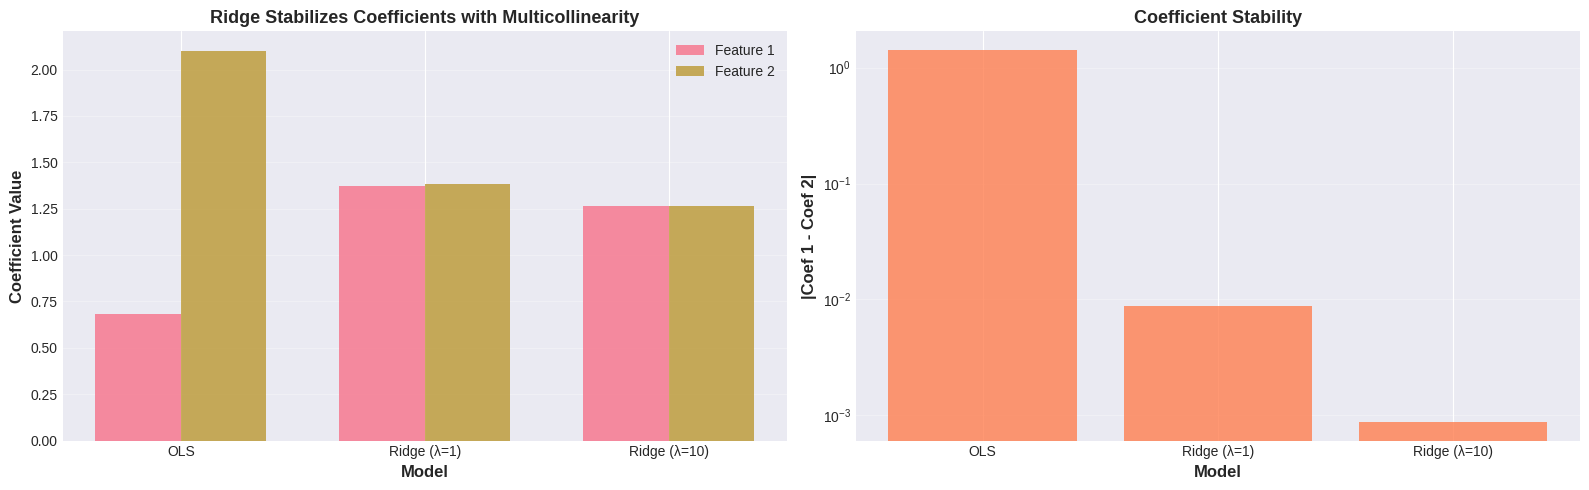


Multicollinearity Handling:
       Model   Coef 1   Coef 2      Sum  Difference       R²
         OLS 0.681128 2.101171 2.782299    1.420042 0.998946
 Ridge (λ=1) 1.373010 1.381740 2.754750    0.008730 0.998833
Ridge (λ=10) 1.264235 1.265113 2.529349    0.000878 0.990674

Observations:
  - OLS produces wildly different coefficients for correlated features
  - Ridge regression stabilizes coefficients
  - Higher λ leads to more similar coefficients
  - R² remains good despite regularization


In [6]:
# Demonstrate Ridge handling multicollinearity

# Create highly correlated features
np.random.seed(42)
n = 50
X_base = np.random.randn(n, 1)

# Create two highly correlated features
X_collinear = np.column_stack([
    X_base + np.random.randn(n, 1) * 0.01,  # Almost identical to X_base
    X_base + np.random.randn(n, 1) * 0.01   # Almost identical to X_base
])

# True relationship: y = 3*X_base + noise
y_collinear = 3 * X_base.ravel() + np.random.randn(n) * 0.1

# Standardize
scaler = StandardScaler()
X_collinear_scaled = scaler.fit_transform(X_collinear)

# Compare OLS vs Ridge
models_compare = {
    'OLS': LinearRegression(),
    'Ridge (λ=1)': Ridge(alpha=1.0),
    'Ridge (λ=10)': Ridge(alpha=10.0)
}

results = []
for name, model in models_compare.items():
    model.fit(X_collinear_scaled, y_collinear)
    coefs = model.coef_
    results.append({
        'Model': name,
        'Coef 1': coefs[0],
        'Coef 2': coefs[1],
        'Sum': coefs.sum(),
        'Difference': abs(coefs[0] - coefs[1]),
        'R²': model.score(X_collinear_scaled, y_collinear)
    })

results_df = pd.DataFrame(results)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot coefficients
ax = axes[0]
x_pos = np.arange(len(models_compare))
width = 0.35

coef1_vals = [r['Coef 1'] for r in results]
coef2_vals = [r['Coef 2'] for r in results]

ax.bar(x_pos - width/2, coef1_vals, width, label='Feature 1', alpha=0.8)
ax.bar(x_pos + width/2, coef2_vals, width, label='Feature 2', alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title('Ridge Stabilizes Coefficients with Multicollinearity', 
            fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models_compare.keys())
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='k', linewidth=0.5)

# Plot coefficient difference
ax = axes[1]
diff_vals = [r['Difference'] for r in results]
ax.bar(x_pos, diff_vals, alpha=0.8, color='coral')
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('|Coef 1 - Coef 2|', fontsize=12, fontweight='bold')
ax.set_title('Coefficient Stability', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models_compare.keys())
ax.grid(True, alpha=0.3, axis='y')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print("\nMulticollinearity Handling:")
print("="*70)
print(results_df.to_string(index=False))
print("\nObservations:")
print("  - OLS produces wildly different coefficients for correlated features")
print("  - Ridge regression stabilizes coefficients")
print("  - Higher λ leads to more similar coefficients")
print("  - R² remains good despite regularization")

## 5. L1 Regularization (Lasso Regression) <a id='lasso'></a>

### Mathematical Formulation

Lasso (Least Absolute Shrinkage and Selection Operator) adds an L1 penalty:

$$\min_{\mathbf{w}} \|\mathbf{y} - \mathbf{Xw}\|_2^2 + \lambda \|\mathbf{w}\|_1$$

Where:
- $\|\mathbf{w}\|_1 = \sum_{j=1}^{p} |w_j|$ is the L1 norm (Manhattan norm)

### Properties

**Sparsity**: Lasso can shrink coefficients exactly to zero, performing automatic feature selection

**No Closed-Form**: Unlike Ridge, Lasso has no closed-form solution and requires iterative optimization (e.g., coordinate descent)

**Feature Selection**: Naturally selects a subset of features by setting others to zero

**Instability with Correlation**: When features are highly correlated, Lasso tends to select one arbitrarily and ignore the others

### Geometric Interpretation

Lasso constrains the solution to lie within an L1 ball (diamond-shaped in 2D):

$$\|\mathbf{w}\|_1 \leq t$$

The sharp corners of the L1 ball make it likely that the solution will have some zero coordinates.

### When to Use Lasso

- When you believe many features are irrelevant (sparse solutions)
- For feature selection and interpretability
- When you want a simpler model
- When $p >> n$ (many more features than samples)

### Comparison with Ridge

| Aspect | Ridge (L2) | Lasso (L1) |
|--------|-----------|------------|
| Penalty | $\sum w_j^2$ | $\sum |w_j|$ |
| Solution | All coefficients non-zero | Some coefficients exactly zero |
| Feature Selection | No | Yes |
| Correlated Features | Coefficients similar | Selects one, zeros others |
| Closed Form | Yes | No |
| Geometry | Circle/Sphere | Diamond/Polyhedron |

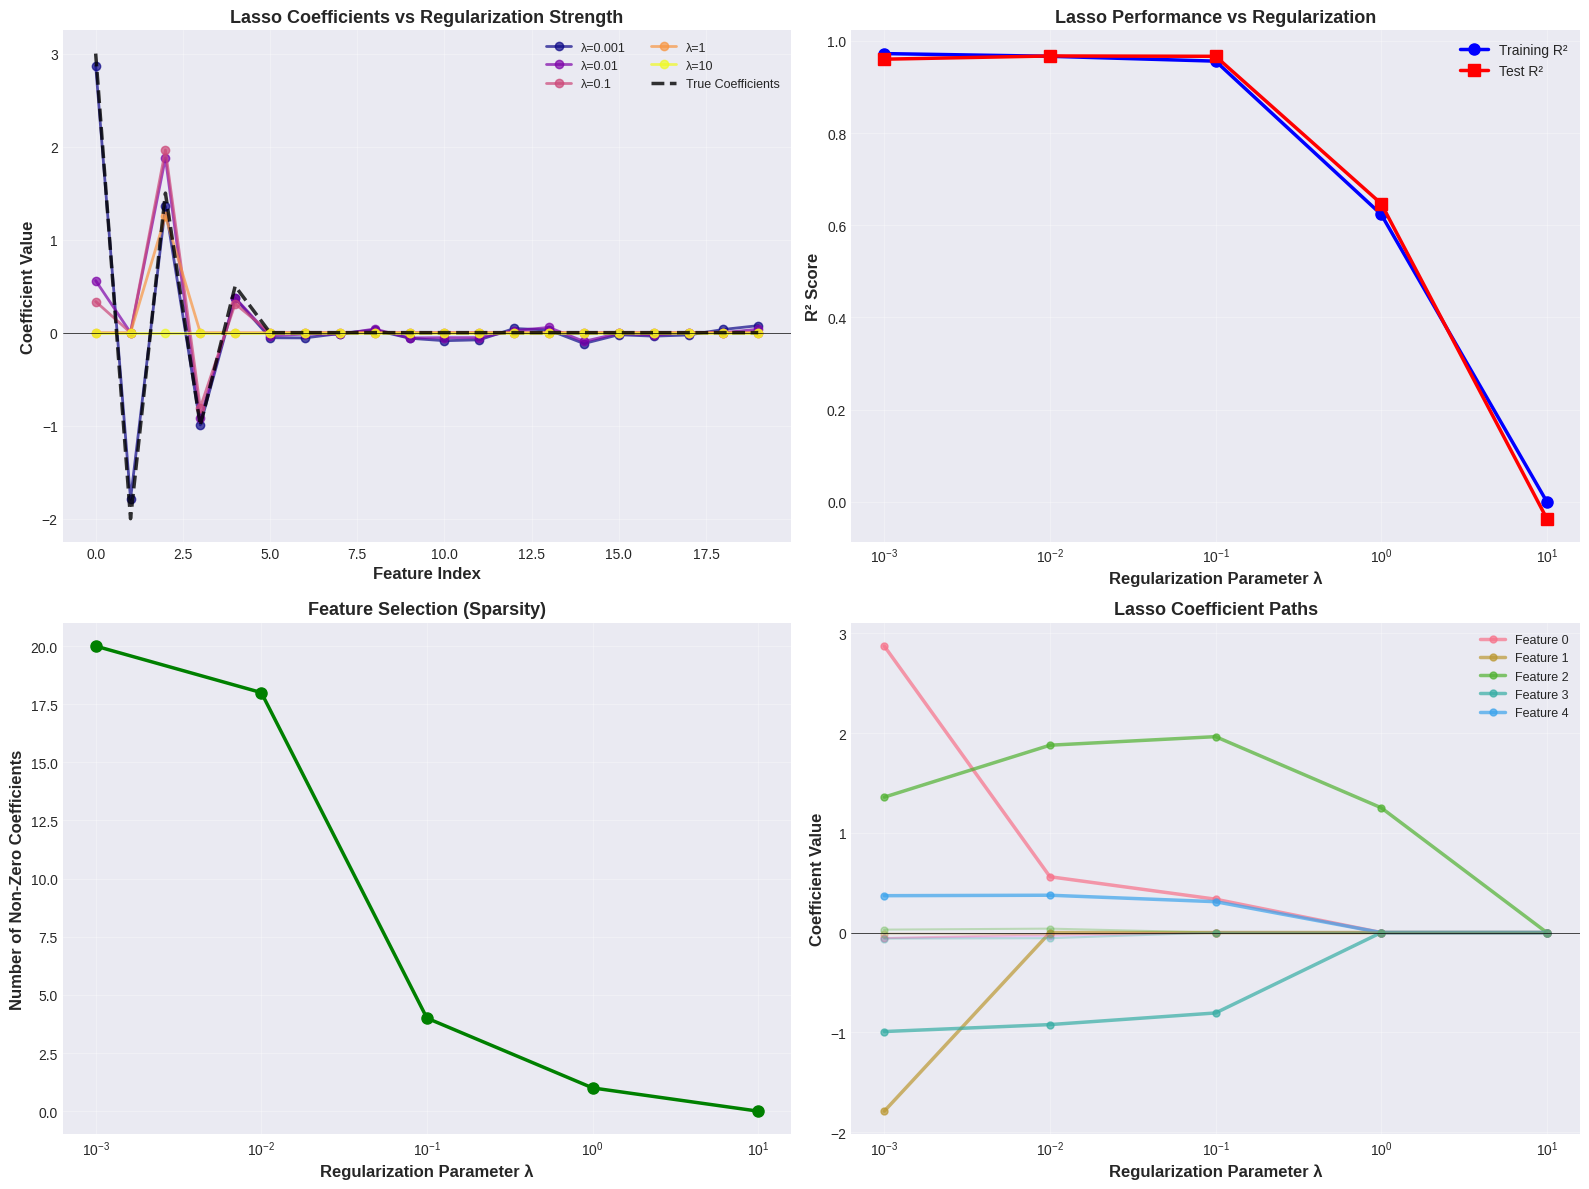

Lasso Regression Results:

λ =  0.001: Train R² = 0.9723, Test R² = 0.9602, Non-zero = 20/20

λ =  0.010: Train R² = 0.9665, Test R² = 0.9672, Non-zero = 18/20

λ =  0.100: Train R² = 0.9559, Test R² = 0.9664, Non-zero = 4/20

λ =  1.000: Train R² = 0.6234, Test R² = 0.6467, Non-zero = 1/20

λ = 10.000: Train R² = 0.0000, Test R² = -0.0367, Non-zero = 0/20

Key Observations:
  - As λ increases, more coefficients become exactly zero
  - Lasso performs automatic feature selection
  - Important features (0-4) remain non-zero longer
  - Coefficient paths show sharp transitions to zero


In [7]:
# Demonstrate Lasso Regression and feature selection

# Use the same data from Ridge example
# Train Lasso with different alpha values
alphas_lasso = [0.001, 0.01, 0.1, 1, 10]
colors_lasso = plt.cm.plasma(np.linspace(0, 1, len(alphas_lasso)))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Store results
train_scores_lasso = []
test_scores_lasso = []
n_nonzero = []
all_coefs_lasso = []

for alpha in alphas_lasso:
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train, y_train)
    
    train_scores_lasso.append(model.score(X_train, y_train))
    test_scores_lasso.append(model.score(X_test, y_test))
    n_nonzero.append(np.sum(model.coef_ != 0))
    all_coefs_lasso.append(model.coef_)

# Plot 1: Coefficient values for different alphas
ax = axes[0, 0]
for idx, (alpha, coefs, color) in enumerate(zip(alphas_lasso, all_coefs_lasso, colors_lasso)):
    ax.plot(coefs, 'o-', color=color, linewidth=2, markersize=6,
           label=f'λ={alpha}', alpha=0.7)
ax.plot(true_coef, 'k--', linewidth=2.5, label='True Coefficients', alpha=0.8)
ax.set_xlabel('Feature Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title('Lasso Coefficients vs Regularization Strength', fontsize=13, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)

# Plot 2: R² scores
ax = axes[0, 1]
ax.plot(alphas_lasso, train_scores_lasso, 'o-', color='blue', linewidth=2.5,
       markersize=8, label='Training R²')
ax.plot(alphas_lasso, test_scores_lasso, 's-', color='red', linewidth=2.5,
       markersize=8, label='Test R²')
ax.set_xlabel('Regularization Parameter λ', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Lasso Performance vs Regularization', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Number of non-zero coefficients
ax = axes[1, 0]
ax.plot(alphas_lasso, n_nonzero, 'o-', color='green', linewidth=2.5, markersize=8)
ax.set_xlabel('Regularization Parameter λ', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Non-Zero Coefficients', fontsize=12, fontweight='bold')
ax.set_title('Feature Selection (Sparsity)', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# Plot 4: Individual coefficient paths
ax = axes[1, 1]
for feature_idx in range(min(10, n_features)):
    coef_path = [coefs[feature_idx] for coefs in all_coefs_lasso]
    alpha_val = 0.7 if feature_idx < 5 else 0.3
    linewidth = 2.5 if feature_idx < 5 else 1.5
    label = f'Feature {feature_idx}' if feature_idx < 5 else None
    ax.plot(alphas_lasso, coef_path, 'o-', linewidth=linewidth, markersize=5,
           alpha=alpha_val, label=label)
ax.set_xlabel('Regularization Parameter λ', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title('Lasso Coefficient Paths', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

print("Lasso Regression Results:")
print("="*70)
for idx, alpha in enumerate(alphas_lasso):
    print(f"\nλ = {alpha:6.3f}: Train R² = {train_scores_lasso[idx]:.4f}, "
          f"Test R² = {test_scores_lasso[idx]:.4f}, Non-zero = {n_nonzero[idx]}/{n_features}")

print("\nKey Observations:")
print("  - As λ increases, more coefficients become exactly zero")
print("  - Lasso performs automatic feature selection")
print("  - Important features (0-4) remain non-zero longer")
print("  - Coefficient paths show sharp transitions to zero")

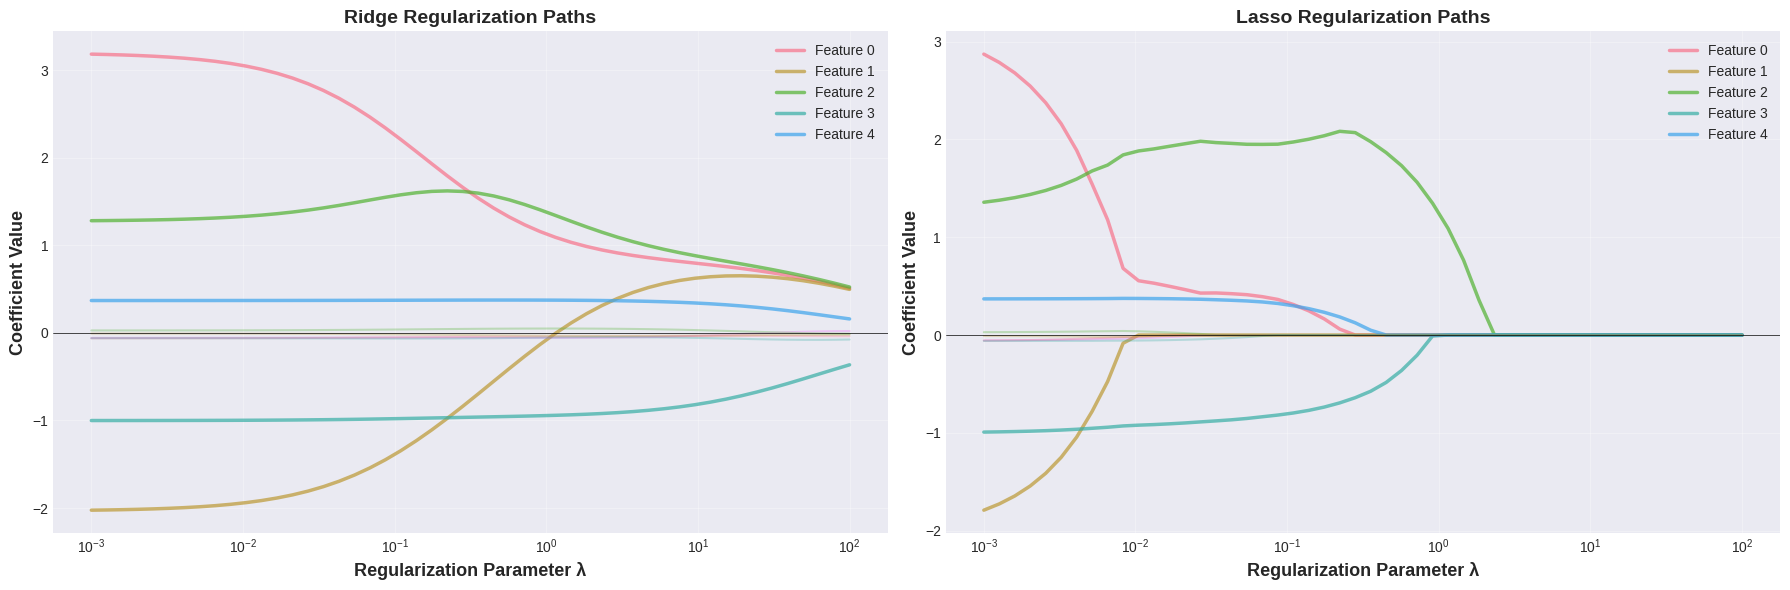


Ridge vs Lasso Comparison:
Ridge (L2 Regularization):
  - Coefficients smoothly approach zero
  - All coefficients remain non-zero
  - Correlated features have similar coefficients

Lasso (L1 Regularization):
  - Coefficients hit zero at specific λ values
  - Creates sparse solutions (many zeros)
  - Sharp transitions in coefficient paths
  - Effective feature selection


In [8]:
# Compare Ridge vs Lasso on the same data

# Use a common set of alpha values
alphas_common = np.logspace(-3, 2, 50)

# Store coefficients for both methods
ridge_coefs_path = []
lasso_coefs_path = []

for alpha in alphas_common:
    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    ridge_coefs_path.append(ridge.coef_)
    
    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    lasso_coefs_path.append(lasso.coef_)

ridge_coefs_path = np.array(ridge_coefs_path)
lasso_coefs_path = np.array(lasso_coefs_path)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Ridge paths
ax = axes[0]
for i in range(min(10, n_features)):
    alpha_val = 0.7 if i < 5 else 0.3
    linewidth = 2.5 if i < 5 else 1.5
    label = f'Feature {i}' if i < 5 else None
    ax.plot(alphas_common, ridge_coefs_path[:, i], linewidth=linewidth,
           alpha=alpha_val, label=label)
ax.set_xlabel('Regularization Parameter λ', fontsize=13, fontweight='bold')
ax.set_ylabel('Coefficient Value', fontsize=13, fontweight='bold')
ax.set_title('Ridge Regularization Paths', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)

# Lasso paths
ax = axes[1]
for i in range(min(10, n_features)):
    alpha_val = 0.7 if i < 5 else 0.3
    linewidth = 2.5 if i < 5 else 1.5
    label = f'Feature {i}' if i < 5 else None
    ax.plot(alphas_common, lasso_coefs_path[:, i], linewidth=linewidth,
           alpha=alpha_val, label=label)
ax.set_xlabel('Regularization Parameter λ', fontsize=13, fontweight='bold')
ax.set_ylabel('Coefficient Value', fontsize=13, fontweight='bold')
ax.set_title('Lasso Regularization Paths', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\nRidge vs Lasso Comparison:")
print("="*70)
print("Ridge (L2 Regularization):")
print("  - Coefficients smoothly approach zero")
print("  - All coefficients remain non-zero")
print("  - Correlated features have similar coefficients")
print("\nLasso (L1 Regularization):")
print("  - Coefficients hit zero at specific λ values")
print("  - Creates sparse solutions (many zeros)")
print("  - Sharp transitions in coefficient paths")
print("  - Effective feature selection")

## 6. Elastic Net Regularization <a id='elastic-net'></a>

### Mathematical Formulation

Elastic Net combines both L1 and L2 penalties:

$$\min_{\mathbf{w}} \|\mathbf{y} - \mathbf{Xw}\|_2^2 + \lambda_1 \|\mathbf{w}\|_1 + \lambda_2 \|\mathbf{w}\|_2^2$$

Often parameterized as:

$$\min_{\mathbf{w}} \|\mathbf{y} - \mathbf{Xw}\|_2^2 + \lambda \left[\alpha \|\mathbf{w}\|_1 + \frac{1-\alpha}{2} \|\mathbf{w}\|_2^2\right]$$

Where:
- $\lambda$ controls overall regularization strength
- $\alpha \in [0, 1]$ is the mixing parameter
  - $\alpha = 1$: Pure Lasso
  - $\alpha = 0$: Pure Ridge
  - $0 < \alpha < 1$: Combination of both

### Properties

**Best of Both Worlds**: Combines advantages of Ridge and Lasso

**Grouped Selection**: Can select groups of correlated features (unlike Lasso)

**Sparsity**: Still produces sparse solutions (like Lasso)

**Stability**: More stable than Lasso with correlated features

### When to Use Elastic Net

- When you have groups of correlated features
- When $p >> n$ and features are correlated
- When you want feature selection but more stability than Lasso
- When you're not sure whether to use Ridge or Lasso

### Advantages

1. **Handles correlated features better than Lasso**: Selects groups rather than picking one
2. **More stable than Lasso**: Less sensitive to random sampling
3. **Maintains sparsity**: Still performs feature selection
4. **Flexible**: Can tune between Ridge and Lasso behavior

### Disadvantages

1. **Two hyperparameters**: Need to tune both $\lambda$ and $\alpha$
2. **Computational cost**: Slightly more expensive than Ridge or Lasso alone
3. **Interpretability**: Less interpretable than pure Ridge or Lasso

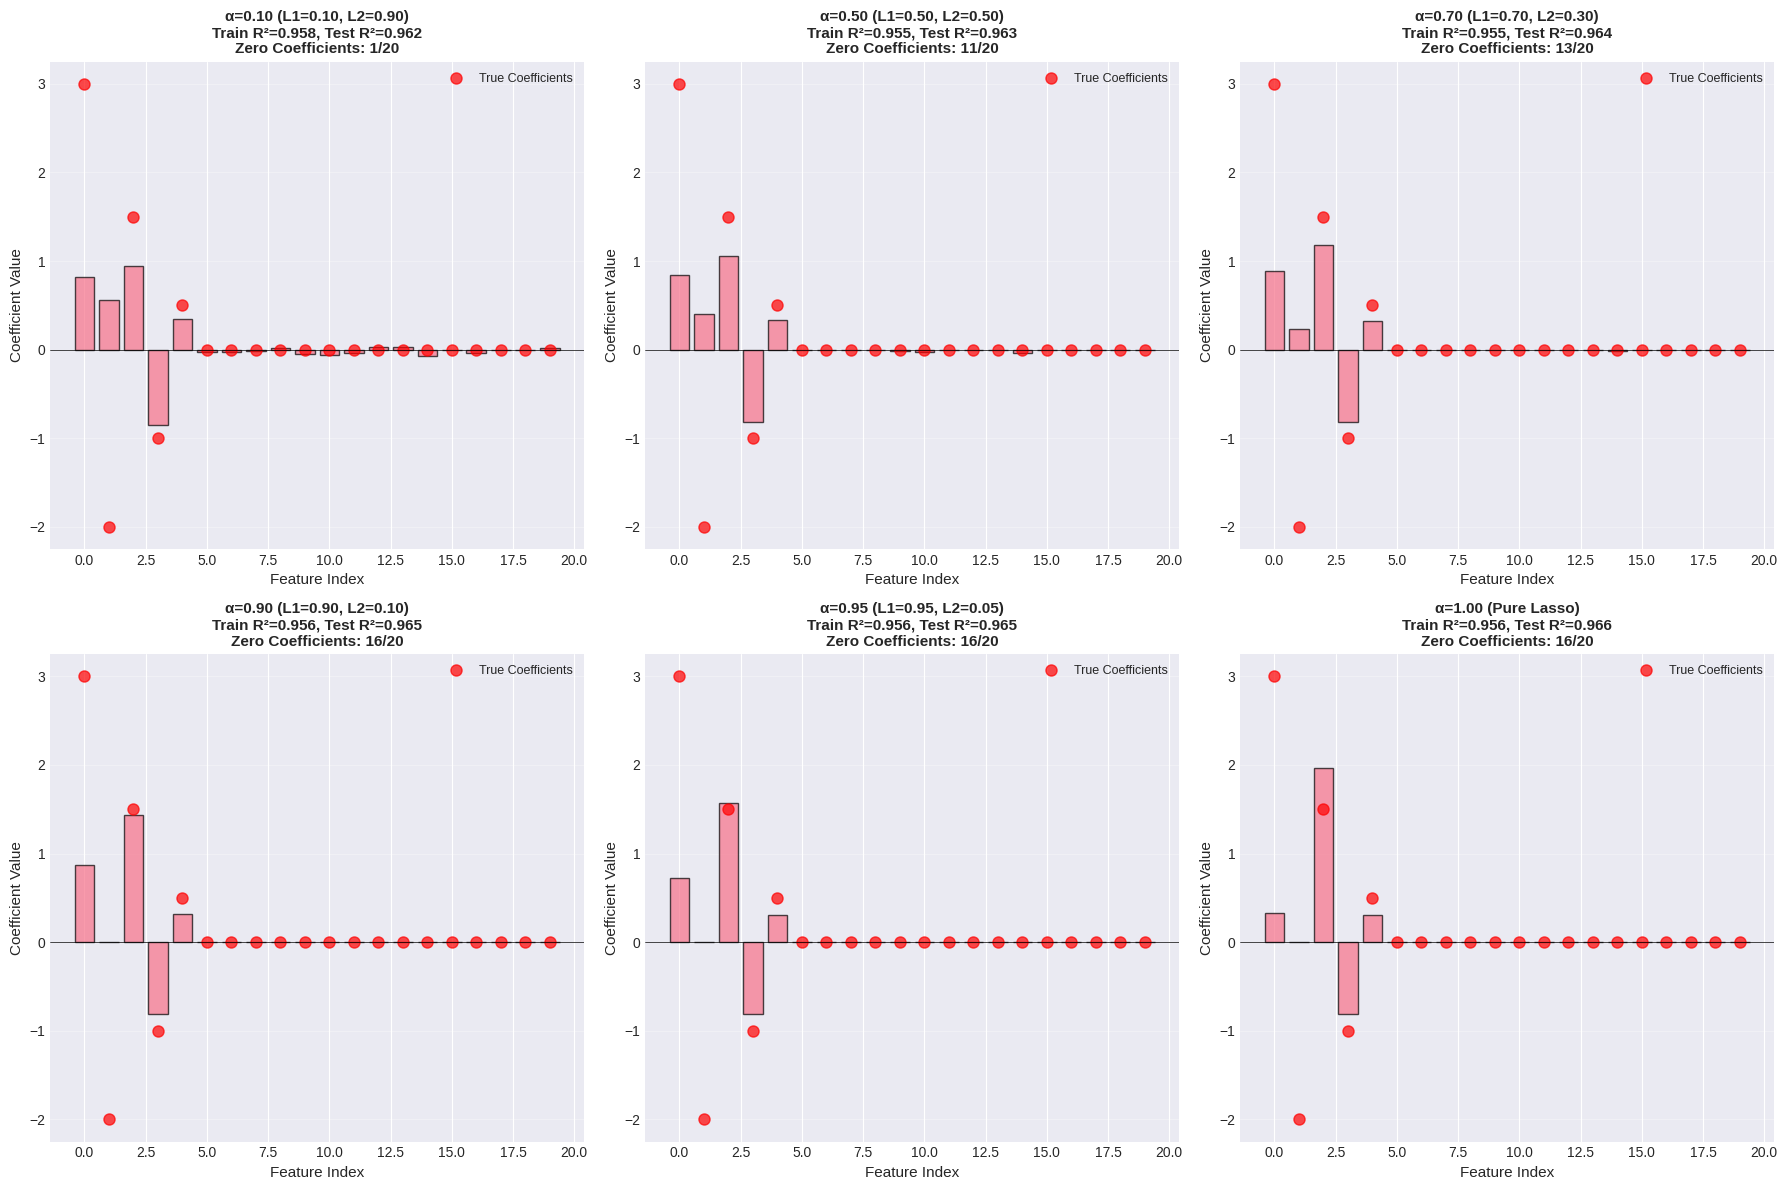

Elastic Net with Different L1 Ratios:

α (l1_ratio) | Behavior
----------------------------------------------------------------------
α = 0.1      | Mostly Ridge (90% L2, 10% L1)
α = 0.5      | Balanced (50% L2, 50% L1)
α = 0.7      | More Lasso (30% L2, 70% L1)
α = 0.9      | Mostly Lasso (10% L2, 90% L1)
α = 0.95     | Almost Pure Lasso
α = 1.0      | Pure Lasso (100% L1)


In [9]:
# Demonstrate Elastic Net

# Test different l1_ratio (alpha) values
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 1.0]
lambda_param = 0.1

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, l1_ratio in enumerate(l1_ratios):
    if l1_ratio == 1.0:
        model = Lasso(alpha=lambda_param, max_iter=10000)
        title_suffix = "(Pure Lasso)"
    else:
        model = ElasticNet(alpha=lambda_param, l1_ratio=l1_ratio, max_iter=10000)
        title_suffix = f"(L1={l1_ratio:.2f}, L2={1-l1_ratio:.2f})"
    
    model.fit(X_train, y_train)
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    n_zero = np.sum(model.coef_ == 0)
    
    # Plot coefficients
    axes[idx].bar(range(n_features), model.coef_, alpha=0.7, edgecolor='black')
    axes[idx].plot(range(n_features), true_coef, 'ro', markersize=8,
                  label='True Coefficients', alpha=0.7)
    
    axes[idx].set_xlabel('Feature Index', fontsize=11)
    axes[idx].set_ylabel('Coefficient Value', fontsize=11)
    axes[idx].set_title(f'α={l1_ratio:.2f} {title_suffix}\n' +
                       f'Train R²={train_score:.3f}, Test R²={test_score:.3f}\n' +
                       f'Zero Coefficients: {n_zero}/{n_features}',
                       fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].axhline(y=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

print("Elastic Net with Different L1 Ratios:")
print("="*70)
print("\nα (l1_ratio) | Behavior")
print("-"*70)
print("α = 0.1      | Mostly Ridge (90% L2, 10% L1)")
print("α = 0.5      | Balanced (50% L2, 50% L1)")
print("α = 0.7      | More Lasso (30% L2, 70% L1)")
print("α = 0.9      | Mostly Lasso (10% L2, 90% L1)")
print("α = 0.95     | Almost Pure Lasso")
print("α = 1.0      | Pure Lasso (100% L1)")

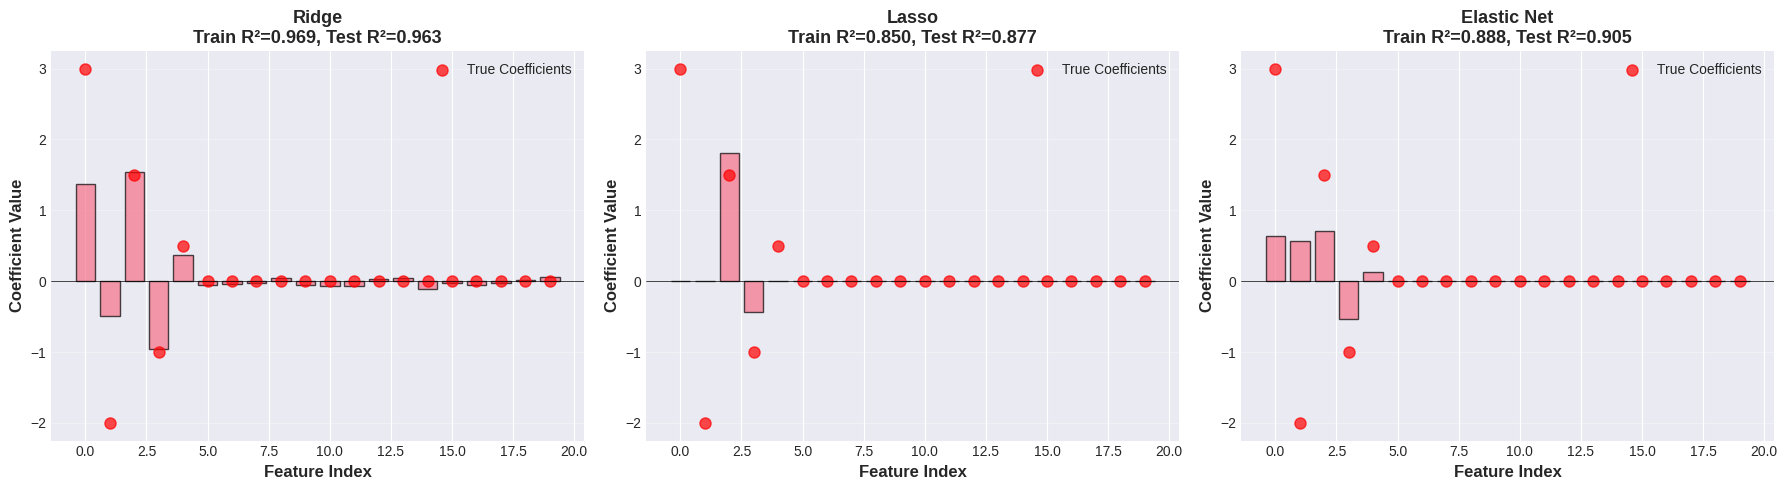


Regularization Methods Comparison (λ = 0.5):
     Method  Train R²  Test R²  Zero Coefs    ||w||
      Ridge  0.969168 0.963134           0 2.371409
      Lasso  0.850480 0.876501          18 1.859256
Elastic Net  0.887569 0.905365          15 1.242806

Summary:
  Ridge:       Keeps all features, shrinks coefficients smoothly
  Lasso:       Selects subset of features, sets many to zero
  Elastic Net: Balances between Ridge and Lasso behavior


In [10]:
# Compare all three regularization methods side by side

# Use fixed lambda for fair comparison
lambda_fixed = 0.5

models_all = {
    'Ridge': Ridge(alpha=lambda_fixed),
    'Lasso': Lasso(alpha=lambda_fixed, max_iter=10000),
    'Elastic Net': ElasticNet(alpha=lambda_fixed, l1_ratio=0.5, max_iter=10000)
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

results_comparison = []

for idx, (name, model) in enumerate(models_all.items()):
    model.fit(X_train, y_train)
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    n_zero = np.sum(model.coef_ == 0)
    coef_norm = np.linalg.norm(model.coef_)
    
    results_comparison.append({
        'Method': name,
        'Train R²': train_score,
        'Test R²': test_score,
        'Zero Coefs': n_zero,
        '||w||': coef_norm
    })
    
    # Plot
    axes[idx].bar(range(n_features), model.coef_, alpha=0.7, edgecolor='black')
    axes[idx].plot(range(n_features), true_coef, 'ro', markersize=8,
                  label='True Coefficients', alpha=0.7)
    axes[idx].set_xlabel('Feature Index', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Coefficient Value', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{name}\nTrain R²={train_score:.3f}, Test R²={test_score:.3f}',
                       fontsize=13, fontweight='bold')
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].axhline(y=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

# Print comparison table
comparison_df = pd.DataFrame(results_comparison)
print("\nRegularization Methods Comparison (λ = 0.5):")
print("="*70)
print(comparison_df.to_string(index=False))

print("\nSummary:")
print("  Ridge:       Keeps all features, shrinks coefficients smoothly")
print("  Lasso:       Selects subset of features, sets many to zero")
print("  Elastic Net: Balances between Ridge and Lasso behavior")

## 7. Regularization Parameter Selection <a id='parameter-selection'></a>

Choosing the right regularization parameter $\lambda$ is crucial for model performance.

### Methods for Selection

**1. Cross-Validation**

The gold standard for hyperparameter selection:
- Split data into k folds
- For each $\lambda$, train on k-1 folds and validate on remaining fold
- Average validation scores across folds
- Select $\lambda$ with best average score

**2. Validation Set**

Simpler but less robust:
- Hold out a validation set
- Train on training set for different $\lambda$ values
- Select $\lambda$ with best validation performance

**3. Information Criteria**

AIC (Akaike Information Criterion):
$$\text{AIC} = n \log(\text{RSS}/n) + 2p$$

BIC (Bayesian Information Criterion):
$$\text{BIC} = n \log(\text{RSS}/n) + p \log(n)$$

**4. Generalized Cross-Validation (GCV)**

Efficient approximation to leave-one-out cross-validation for Ridge regression.

### Built-in CV Methods

Scikit-learn provides:
- `RidgeCV`: Ridge with built-in cross-validation
- `LassoCV`: Lasso with built-in cross-validation
- `ElasticNetCV`: Elastic Net with built-in cross-validation

These automatically find the optimal $\lambda$.

### Grid Search vs Random Search

**Grid Search**: Test all combinations of parameters
- Exhaustive but computationally expensive
- Good when you have limited hyperparameters

**Random Search**: Sample random combinations
- More efficient for high-dimensional parameter spaces
- Often finds good solutions faster

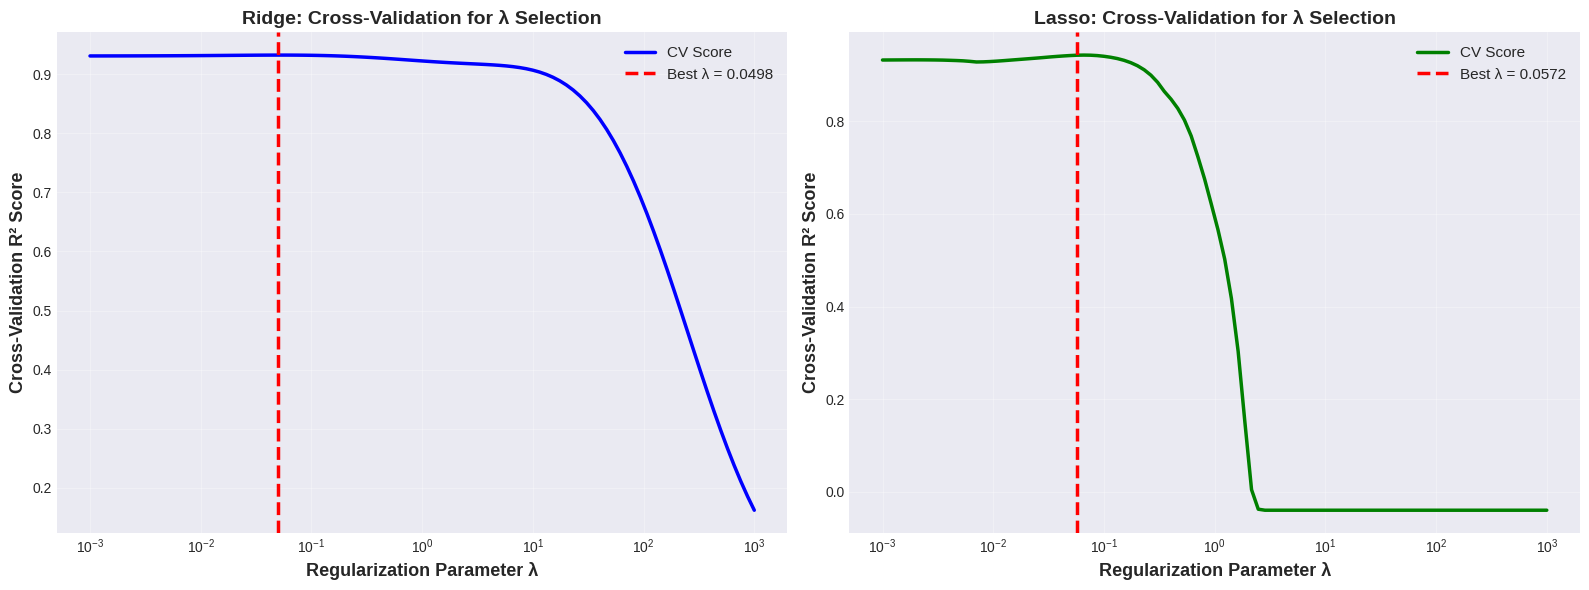

Hyperparameter Tuning Results:

Ridge:
  Best λ: 0.049770
  Train R²: 0.9722
  Test R²: 0.9609

Lasso:
  Best λ: 0.057224
  Train R²: 0.9611
  Test R²: 0.9692
  Non-zero coefficients: 8/20

Key Points:
  - Cross-validation provides unbiased estimate of generalization
  - CV score shows inverted U-shape: too small or large λ hurts performance
  - Built-in CV methods (RidgeCV, LassoCV) are convenient and efficient


In [11]:
# Demonstrate hyperparameter tuning with cross-validation

# Define range of alpha values to test
alphas_cv = np.logspace(-3, 3, 100)

# Ridge with built-in CV
ridge_cv = RidgeCV(alphas=alphas_cv, cv=5)
ridge_cv.fit(X_train, y_train)
best_alpha_ridge = ridge_cv.alpha_

# Lasso with built-in CV
lasso_cv = LassoCV(alphas=alphas_cv, cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.alpha_

# Manual cross-validation for comparison
from sklearn.model_selection import cross_val_score

ridge_cv_scores = []
lasso_cv_scores = []

for alpha in alphas_cv:
    # Ridge
    ridge = Ridge(alpha=alpha)
    scores_ridge = cross_val_score(ridge, X_train, y_train, cv=5, 
                                   scoring='r2')
    ridge_cv_scores.append(scores_ridge.mean())
    
    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores_lasso = cross_val_score(lasso, X_train, y_train, cv=5,
                                   scoring='r2')
    lasso_cv_scores.append(scores_lasso.mean())

# Plot CV scores
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ridge CV
ax = axes[0]
ax.plot(alphas_cv, ridge_cv_scores, 'b-', linewidth=2.5, label='CV Score')
ax.axvline(best_alpha_ridge, color='red', linestyle='--', linewidth=2.5,
          label=f'Best λ = {best_alpha_ridge:.4f}')
ax.set_xlabel('Regularization Parameter λ', fontsize=13, fontweight='bold')
ax.set_ylabel('Cross-Validation R² Score', fontsize=13, fontweight='bold')
ax.set_title('Ridge: Cross-Validation for λ Selection', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Lasso CV
ax = axes[1]
ax.plot(alphas_cv, lasso_cv_scores, 'g-', linewidth=2.5, label='CV Score')
ax.axvline(best_alpha_lasso, color='red', linestyle='--', linewidth=2.5,
          label=f'Best λ = {best_alpha_lasso:.4f}')
ax.set_xlabel('Regularization Parameter λ', fontsize=13, fontweight='bold')
ax.set_ylabel('Cross-Validation R² Score', fontsize=13, fontweight='bold')
ax.set_title('Lasso: Cross-Validation for λ Selection', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate best models
print("Hyperparameter Tuning Results:")
print("="*70)
print(f"\nRidge:")
print(f"  Best λ: {best_alpha_ridge:.6f}")
print(f"  Train R²: {ridge_cv.score(X_train, y_train):.4f}")
print(f"  Test R²: {ridge_cv.score(X_test, y_test):.4f}")
print(f"\nLasso:")
print(f"  Best λ: {best_alpha_lasso:.6f}")
print(f"  Train R²: {lasso_cv.score(X_train, y_train):.4f}")
print(f"  Test R²: {lasso_cv.score(X_test, y_test):.4f}")
print(f"  Non-zero coefficients: {np.sum(lasso_cv.coef_ != 0)}/{n_features}")

print("\nKey Points:")
print("  - Cross-validation provides unbiased estimate of generalization")
print("  - CV score shows inverted U-shape: too small or large λ hurts performance")
print("  - Built-in CV methods (RidgeCV, LassoCV) are convenient and efficient")

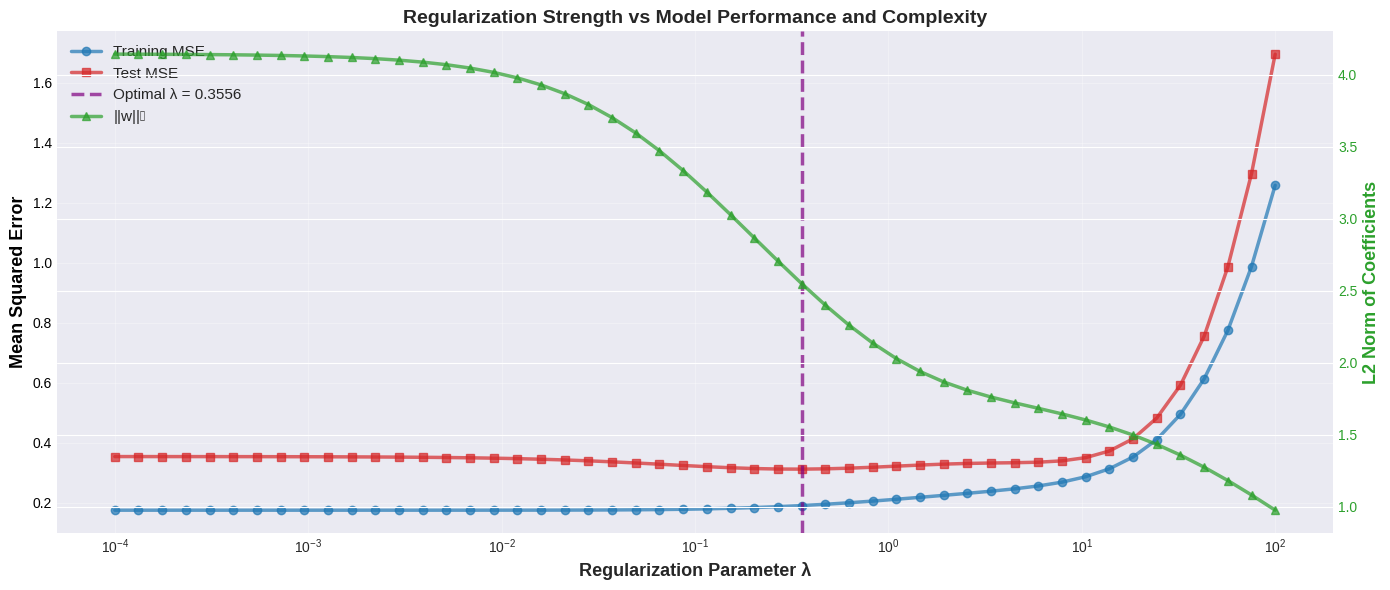


Optimal Regularization Parameter: λ = 0.355648
Minimum Test MSE: 0.312673
Corresponding Coefficient Norm: 2.5510

Observations:
  - As λ increases, training error increases (less fitting)
  - Test error decreases then increases (U-shaped curve)
  - Coefficient norm decreases monotonically with λ
  - Optimal λ balances bias and variance


In [12]:
# Visualize the effect of regularization parameter on test performance

# Test a range of alphas
alphas_test = np.logspace(-4, 2, 50)
train_errors = []
test_errors = []
coefficients_l2_norms = []

for alpha in alphas_test:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, train_pred))
    test_errors.append(mean_squared_error(y_test, test_pred))
    coefficients_l2_norms.append(np.linalg.norm(model.coef_))

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))

color1 = 'tab:blue'
color2 = 'tab:red'
color3 = 'tab:green'

ax1.set_xlabel('Regularization Parameter λ', fontsize=13, fontweight='bold')
ax1.set_ylabel('Mean Squared Error', fontsize=13, fontweight='bold', color='black')
ax1.plot(alphas_test, train_errors, 'o-', color=color1, linewidth=2.5,
        markersize=6, label='Training MSE', alpha=0.7)
ax1.plot(alphas_test, test_errors, 's-', color=color2, linewidth=2.5,
        markersize=6, label='Test MSE', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)

# Create second y-axis for coefficient norm
ax2 = ax1.twinx()
ax2.set_ylabel('L2 Norm of Coefficients', fontsize=13, fontweight='bold', color=color3)
ax2.plot(alphas_test, coefficients_l2_norms, '^-', color=color3, linewidth=2.5,
        markersize=6, label='||w||₂', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color3)

# Add vertical line for optimal alpha
optimal_idx = np.argmin(test_errors)
optimal_alpha = alphas_test[optimal_idx]
ax1.axvline(optimal_alpha, color='purple', linestyle='--', linewidth=2.5,
           label=f'Optimal λ = {optimal_alpha:.4f}', alpha=0.7)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=11, loc='upper left')

plt.title('Regularization Strength vs Model Performance and Complexity',
         fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nOptimal Regularization Parameter: λ = {optimal_alpha:.6f}")
print(f"Minimum Test MSE: {min(test_errors):.6f}")
print(f"Corresponding Coefficient Norm: {coefficients_l2_norms[optimal_idx]:.4f}")
print("\nObservations:")
print("  - As λ increases, training error increases (less fitting)")
print("  - Test error decreases then increases (U-shaped curve)")
print("  - Coefficient norm decreases monotonically with λ")
print("  - Optimal λ balances bias and variance")

## 8. Feature Selection with Regularization <a id='feature-selection'></a>

One of the most powerful applications of regularization, especially Lasso, is automatic feature selection.

### Why Feature Selection Matters

**Interpretability**: Simpler models are easier to understand and explain

**Computational Efficiency**: Fewer features mean faster training and prediction

**Reduced Overfitting**: Fewer parameters mean less chance of overfitting

**Better Generalization**: Removing irrelevant features can improve performance

### Lasso for Feature Selection

Lasso's L1 penalty naturally drives some coefficients to exactly zero:
- Features with zero coefficients can be removed
- Remaining features form a sparse model
- Selection is data-driven and automatic

### Feature Selection Process

1. **Standardize features** (crucial for fair comparison)
2. **Apply Lasso** with appropriate $\lambda$
3. **Identify features** with non-zero coefficients
4. **Retrain** (optional) using only selected features

### Stability Selection

To make feature selection more robust:
- Run Lasso on multiple bootstrap samples
- Count how often each feature is selected
- Keep features selected in most samples
- More stable than single Lasso run

### Alternative Methods

**Recursive Feature Elimination (RFE)**:
- Iteratively remove least important features
- Can use with any model that provides feature importance

**Tree-based Methods**:
- Random Forest, Gradient Boosting provide feature importance
- Can identify non-linear relationships

**Univariate Selection**:
- Test each feature independently
- Fast but ignores feature interactions

Feature Selection Results:
Total features: 50
Informative features: 10
Features selected by Lasso: 22
Optimal λ: 0.766431

Selected feature indices: [1, 2, 4, 5, 7, 12, 13, 14, 16, 18, 19, 21, 22, 23, 31, 32, 35, 40, 42, 44, 45, 48]


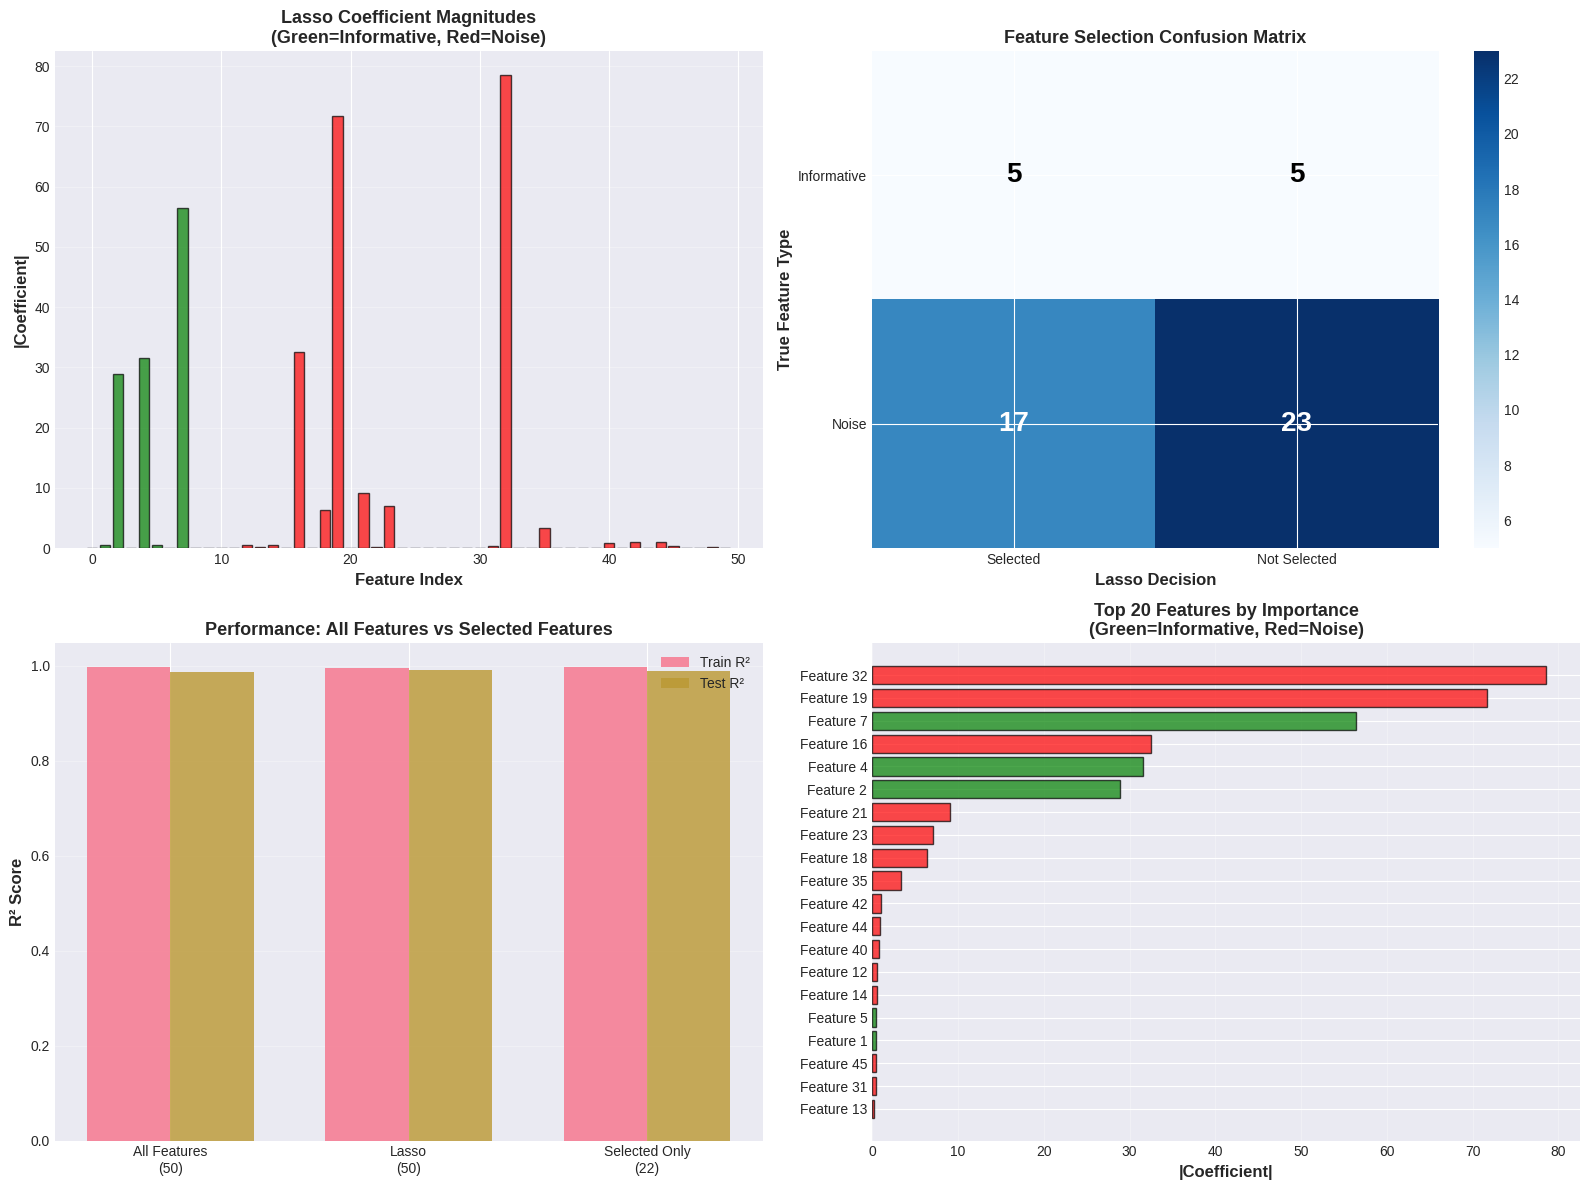


Feature Selection Metrics:
  Precision: 0.227 (of selected features, how many are informative)
  Recall: 0.500 (of informative features, how many were selected)
  F1 Score: 0.312

Model Performance Comparison:
  All Features:      Train R²=0.9970, Test R²=0.9862
  Lasso:             Train R²=0.9956, Test R²=0.9903
  Selected Features: Train R²=0.9963, Test R²=0.9887


In [13]:
# Demonstrate feature selection with Lasso

# Create dataset with mix of relevant and irrelevant features
np.random.seed(42)
n_samples_fs = 200
n_features_fs = 50
n_informative = 10

# Generate data
X_fs, y_fs = make_regression(n_samples=n_samples_fs, n_features=n_features_fs,
                             n_informative=n_informative, noise=10, random_state=42)

# Standardize
scaler_fs = StandardScaler()
X_fs_scaled = scaler_fs.fit_transform(X_fs)

# Split
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
    X_fs_scaled, y_fs, test_size=0.3, random_state=42
)

# Use LassoCV to find optimal alpha
lasso_fs = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_fs.fit(X_train_fs, y_train_fs)

# Get feature selection results
selected_features = np.where(lasso_fs.coef_ != 0)[0]
n_selected = len(selected_features)

print(f"Feature Selection Results:")
print("="*70)
print(f"Total features: {n_features_fs}")
print(f"Informative features: {n_informative}")
print(f"Features selected by Lasso: {n_selected}")
print(f"Optimal λ: {lasso_fs.alpha_:.6f}")
print(f"\nSelected feature indices: {selected_features.tolist()}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Coefficient magnitudes
ax = axes[0, 0]
colors_coef = ['green' if i < n_informative else 'red' for i in range(n_features_fs)]
bars = ax.bar(range(n_features_fs), np.abs(lasso_fs.coef_), 
             color=colors_coef, alpha=0.7, edgecolor='black')
ax.set_xlabel('Feature Index', fontsize=12, fontweight='bold')
ax.set_ylabel('|Coefficient|', fontsize=12, fontweight='bold')
ax.set_title(f'Lasso Coefficient Magnitudes\n(Green=Informative, Red=Noise)',
            fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Selected vs non-selected features
ax = axes[0, 1]
selection_mask = lasso_fs.coef_ != 0
labels = ['Selected' if m else 'Not Selected' for m in selection_mask]
informative_mask = np.arange(n_features_fs) < n_informative

# Create confusion matrix for feature selection
true_positive = np.sum(selection_mask & informative_mask)
false_positive = np.sum(selection_mask & ~informative_mask)
true_negative = np.sum(~selection_mask & ~informative_mask)
false_negative = np.sum(~selection_mask & informative_mask)

confusion = np.array([[true_positive, false_negative],
                     [false_positive, true_negative]])

im = ax.imshow(confusion, cmap='Blues', aspect='auto')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Selected', 'Not Selected'])
ax.set_yticklabels(['Informative', 'Noise'])
ax.set_xlabel('Lasso Decision', fontsize=12, fontweight='bold')
ax.set_ylabel('True Feature Type', fontsize=12, fontweight='bold')
ax.set_title('Feature Selection Confusion Matrix', fontsize=13, fontweight='bold')

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, confusion[i, j], ha="center", va="center",
                      color="white" if confusion[i, j] > confusion.max()/2 else "black",
                      fontsize=20, fontweight='bold')

plt.colorbar(im, ax=ax)

# Plot 3: Performance comparison
ax = axes[1, 0]

# Train model with all features
model_all = LinearRegression()
model_all.fit(X_train_fs, y_train_fs)
r2_all_train = model_all.score(X_train_fs, y_train_fs)
r2_all_test = model_all.score(X_test_fs, y_test_fs)

# Train model with selected features only
X_train_selected = X_train_fs[:, selected_features]
X_test_selected = X_test_fs[:, selected_features]
model_selected = LinearRegression()
model_selected.fit(X_train_selected, y_train_fs)
r2_selected_train = model_selected.score(X_train_selected, y_train_fs)
r2_selected_test = model_selected.score(X_test_selected, y_test_fs)

# Lasso performance
r2_lasso_train = lasso_fs.score(X_train_fs, y_train_fs)
r2_lasso_test = lasso_fs.score(X_test_fs, y_test_fs)

x_models = np.arange(3)
width = 0.35
train_scores_comp = [r2_all_train, r2_lasso_train, r2_selected_train]
test_scores_comp = [r2_all_test, r2_lasso_test, r2_selected_test]

ax.bar(x_models - width/2, train_scores_comp, width, label='Train R²', alpha=0.8)
ax.bar(x_models + width/2, test_scores_comp, width, label='Test R²', alpha=0.8)

ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Performance: All Features vs Selected Features', fontsize=13, fontweight='bold')
ax.set_xticks(x_models)
ax.set_xticklabels(['All Features\n(50)', f'Lasso\n(50)', f'Selected Only\n({n_selected})'])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Feature importance ranking
ax = axes[1, 1]
coef_abs = np.abs(lasso_fs.coef_)
sorted_idx = np.argsort(coef_abs)[::-1]
top_n = 20

colors_importance = ['green' if i < n_informative else 'red' for i in sorted_idx[:top_n]]
ax.barh(range(top_n), coef_abs[sorted_idx[:top_n]], color=colors_importance,
       alpha=0.7, edgecolor='black')
ax.set_yticks(range(top_n))
ax.set_yticklabels([f'Feature {i}' for i in sorted_idx[:top_n]])
ax.set_xlabel('|Coefficient|', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features by Importance\n(Green=Informative, Red=Noise)',
            fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Calculate selection metrics
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nFeature Selection Metrics:")
print(f"  Precision: {precision:.3f} (of selected features, how many are informative)")
print(f"  Recall: {recall:.3f} (of informative features, how many were selected)")
print(f"  F1 Score: {f1:.3f}")
print(f"\nModel Performance Comparison:")
print(f"  All Features:      Train R²={r2_all_train:.4f}, Test R²={r2_all_test:.4f}")
print(f"  Lasso:             Train R²={r2_lasso_train:.4f}, Test R²={r2_lasso_test:.4f}")
print(f"  Selected Features: Train R²={r2_selected_train:.4f}, Test R²={r2_selected_test:.4f}")

## 9. Summary and Best Practices

### Key Concepts Recap

**Regularization Purpose**: Prevent overfitting by penalizing model complexity

**Types**:
- **L2 (Ridge)**: Shrinks coefficients, keeps all features
- **L1 (Lasso)**: Performs feature selection, creates sparse models
- **Elastic Net**: Combines L1 and L2, best of both worlds

**Bias-Variance Trade-off**: Regularization increases bias slightly to significantly reduce variance

### When to Use Each Method

**Use Ridge when**:
- You want to keep all features
- Features are correlated
- You need stable coefficient estimates

**Use Lasso when**:
- You want automatic feature selection
- You believe many features are irrelevant
- You need an interpretable model

**Use Elastic Net when**:
- You have groups of correlated features
- You want feature selection but more stability than Lasso
- You're not sure which regularization to use

### Best Practices

**1. Always Standardize Features**
- Regularization is scale-dependent
- Use StandardScaler or similar

**2. Use Cross-Validation for λ Selection**
- Don't rely on a single validation set
- Use RidgeCV, LassoCV, or GridSearchCV

**3. Check Learning Curves**
- Diagnose underfitting vs overfitting
- Guide model complexity decisions

**4. Start with Simple Models**
- Begin with linear models + regularization
- Only increase complexity if needed

**5. Monitor Both Training and Test Performance**
- Large gap indicates overfitting
- Both low indicates underfitting

**6. Consider Domain Knowledge**
- Some features may be known to be important
- Can inform choice of regularization method

### Common Mistakes to Avoid

**Forgetting to standardize**: Results in unfair penalization

**Using same data for training and validation**: Leads to overfitting

**Choosing λ based on training error**: Should use validation/CV

**Not trying multiple regularization types**: Different methods work better for different problems

**Ignoring regularization entirely**: Even simple models benefit from regularization

### Final Thoughts

Regularization is one of the most important tools in machine learning. It:
- Improves generalization
- Enables learning with limited data
- Provides automatic feature selection (Lasso)
- Handles multicollinearity (Ridge)
- Makes models more interpretable

Understanding regularization deeply will make you a better machine learning practitioner.